# SMARTS - Identificando compostos não-orgânicos em um dataset

SMARTS (SMiles ARbitrary Target Specification) é uma linguagem usada na quiminformática para especificação de estruturas químicas e **padrões** dentro delas. É similar ao SMILES (Simplified Molecular Input Line Entry System), que é uma representação em texto de uma estrutura molecular.

Entretanto, enquanto o SMILES descreve uma molécula específica, os SMARTS podem descrever um **padrão geral ou subestrutura**, por exemplo, um grupo ácido carboxílico genérico (-COOH). Podemos usá-los em tarefas como buscas em banco de dados por moléculas que contenham uma subestrutura específica, ou para identificar moléculas similares baseadas em subestruturas comuns.

A sintaxe do SMARTS permite a especificação de átomos, ligações e operadores lógicos, além do uso de "curingas". Por exemplo, o padrão SMARTS "C(=O)O" iria corresponder a qualquer molécula com um grupo funcional de ácido carboxílico, independentemente de suas outras características estruturais.

As regras para uso de SMARTS e alguns exemplos podem ser encontrados [aqui](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html), em inglês.

As análises em quiminformática podem ser limitadas pela presença de átomos relacionados a compostos inorgânicos, como complexos metálicos e sais com metais como contra-íons. Isso porque muitos métodos em quiminformática foram desenvolvidos para lidar com moléculas orgânicas, que geralmente não contêm átomos metálicos. Veja, por exemplo, o método [ANI-2x](https://chemrxiv.org/engage/chemrxiv/article-details/60c747e9567dfec574ec48df), de 2020, para cálculo de energia de moléculas usando aprendizado de máquina. Os autores optaram por limitar o modelo aos elementos (H, C, N, O, F, Cl, S), que, segundo os autores, é o suficiente para cobrir cerca de 90% dos compostos similares a fármacos (*drug-like*)

Vemos, portanto, que é importante conseguir identificar compostos contendo átomos "não-orgânicos" em um conjunto de dados contendo diversos compostos.

Essa é a lista de átomos que normalmente são considerados como componentes de substâncias orgânicas, e que vamos usar neste *Notebook*:

**H, B, C, N, O, F, P, Cl, Br, I**

Vamos demonstrar como construir uma lista de padrões SMARTS e como usá-la para remover de um banco de dados as estruturas que contêm átomos fora dessa lista.

In [1]:
import pandas as pd
from rdkit import Chem

In [2]:
# Importar dataset
df_chembl = pd.read_csv(r"../datasets/tcruzi_chembl_03-02-2022.csv", sep=";", index_col=False)

In [3]:
df_chembl.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties'],
      dtype='object')

In [4]:
# Selecionar apenas as colunas com o ID, SMILES, e atividade
df_chembl = df_chembl[['Molecule ChEMBL ID', 'Smiles', 'pChEMBL Value']]
df_chembl = df_chembl.dropna(subset=['Smiles', 'pChEMBL Value'])

Vamos criar uma função para identificar os compostos com átomos não-orgânicos. Primeiramente, criamos uma lista de SMARTS (`not_organic_pat`), que será usada para identificar as subestruturas em cada molécula. 

Pontos importantes:
1. Podemos identificar elementos usando números (que representam os números atômicos) ou letras. Por exemplo, #6 representa o carbono, e F representa o flúor. É recomendável usar números quando a representação por texto pode ser ambígua. Por exemplo, o elemento escândio (Sc) pode ser confundido com enxofre (S) seguido de carbono aromático (c minúsculo).
2. Usamos o operador lógico `!`, que representa "oposto", ou seja, estamos dizendo que o *match* será positivo quando a estrutura contiver um átomo que não seja nenhum desses identificados na lista de SMARTS.
3. Por fim, note que estamos usando a função MolFromSmarts do RDKit para essa tarefa. Você pode encontrar diversos exemplos de usos de SMARTS usando o RDKit na página [Getting Started with the RDKit in Python](https://www.rdkit.org/docs/GettingStartedInPython.html)

Em seguida, declaramos a função `non_organic`, que recebe um SMILES como *input* e retorna `True` se a estrutura contém um átomo inorgânico, ou `None`, caso não tenha sido possível realizar a conversão do SMILES a RDKit Mol.

In [5]:
# Lista de subestruturas SMARTS
not_organic_pat = Chem.MolFromSmarts("[!#5;!#6;!#7;!#8;!#16;!#15;!F;!Cl;!Br;!I;!#1]")

def non_organic(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        return bool(mol.GetSubstructMatch(not_organic_pat))
    except (AttributeError, TypeError):  # fail to convert to rdkit_mol
        return None

Usamos a função para criar a coluna `not_org`, que identifica as substâncias inorgânicas.

In [6]:
df_chembl["not_org"] = df_chembl["Smiles"].apply(non_organic)

In [7]:
# Total de substâncias contendo átomos não-orgânicos
df_chembl["not_org"].sum()

36

Vamos visualizar as 36 substâncias identificadas pela nossa função:

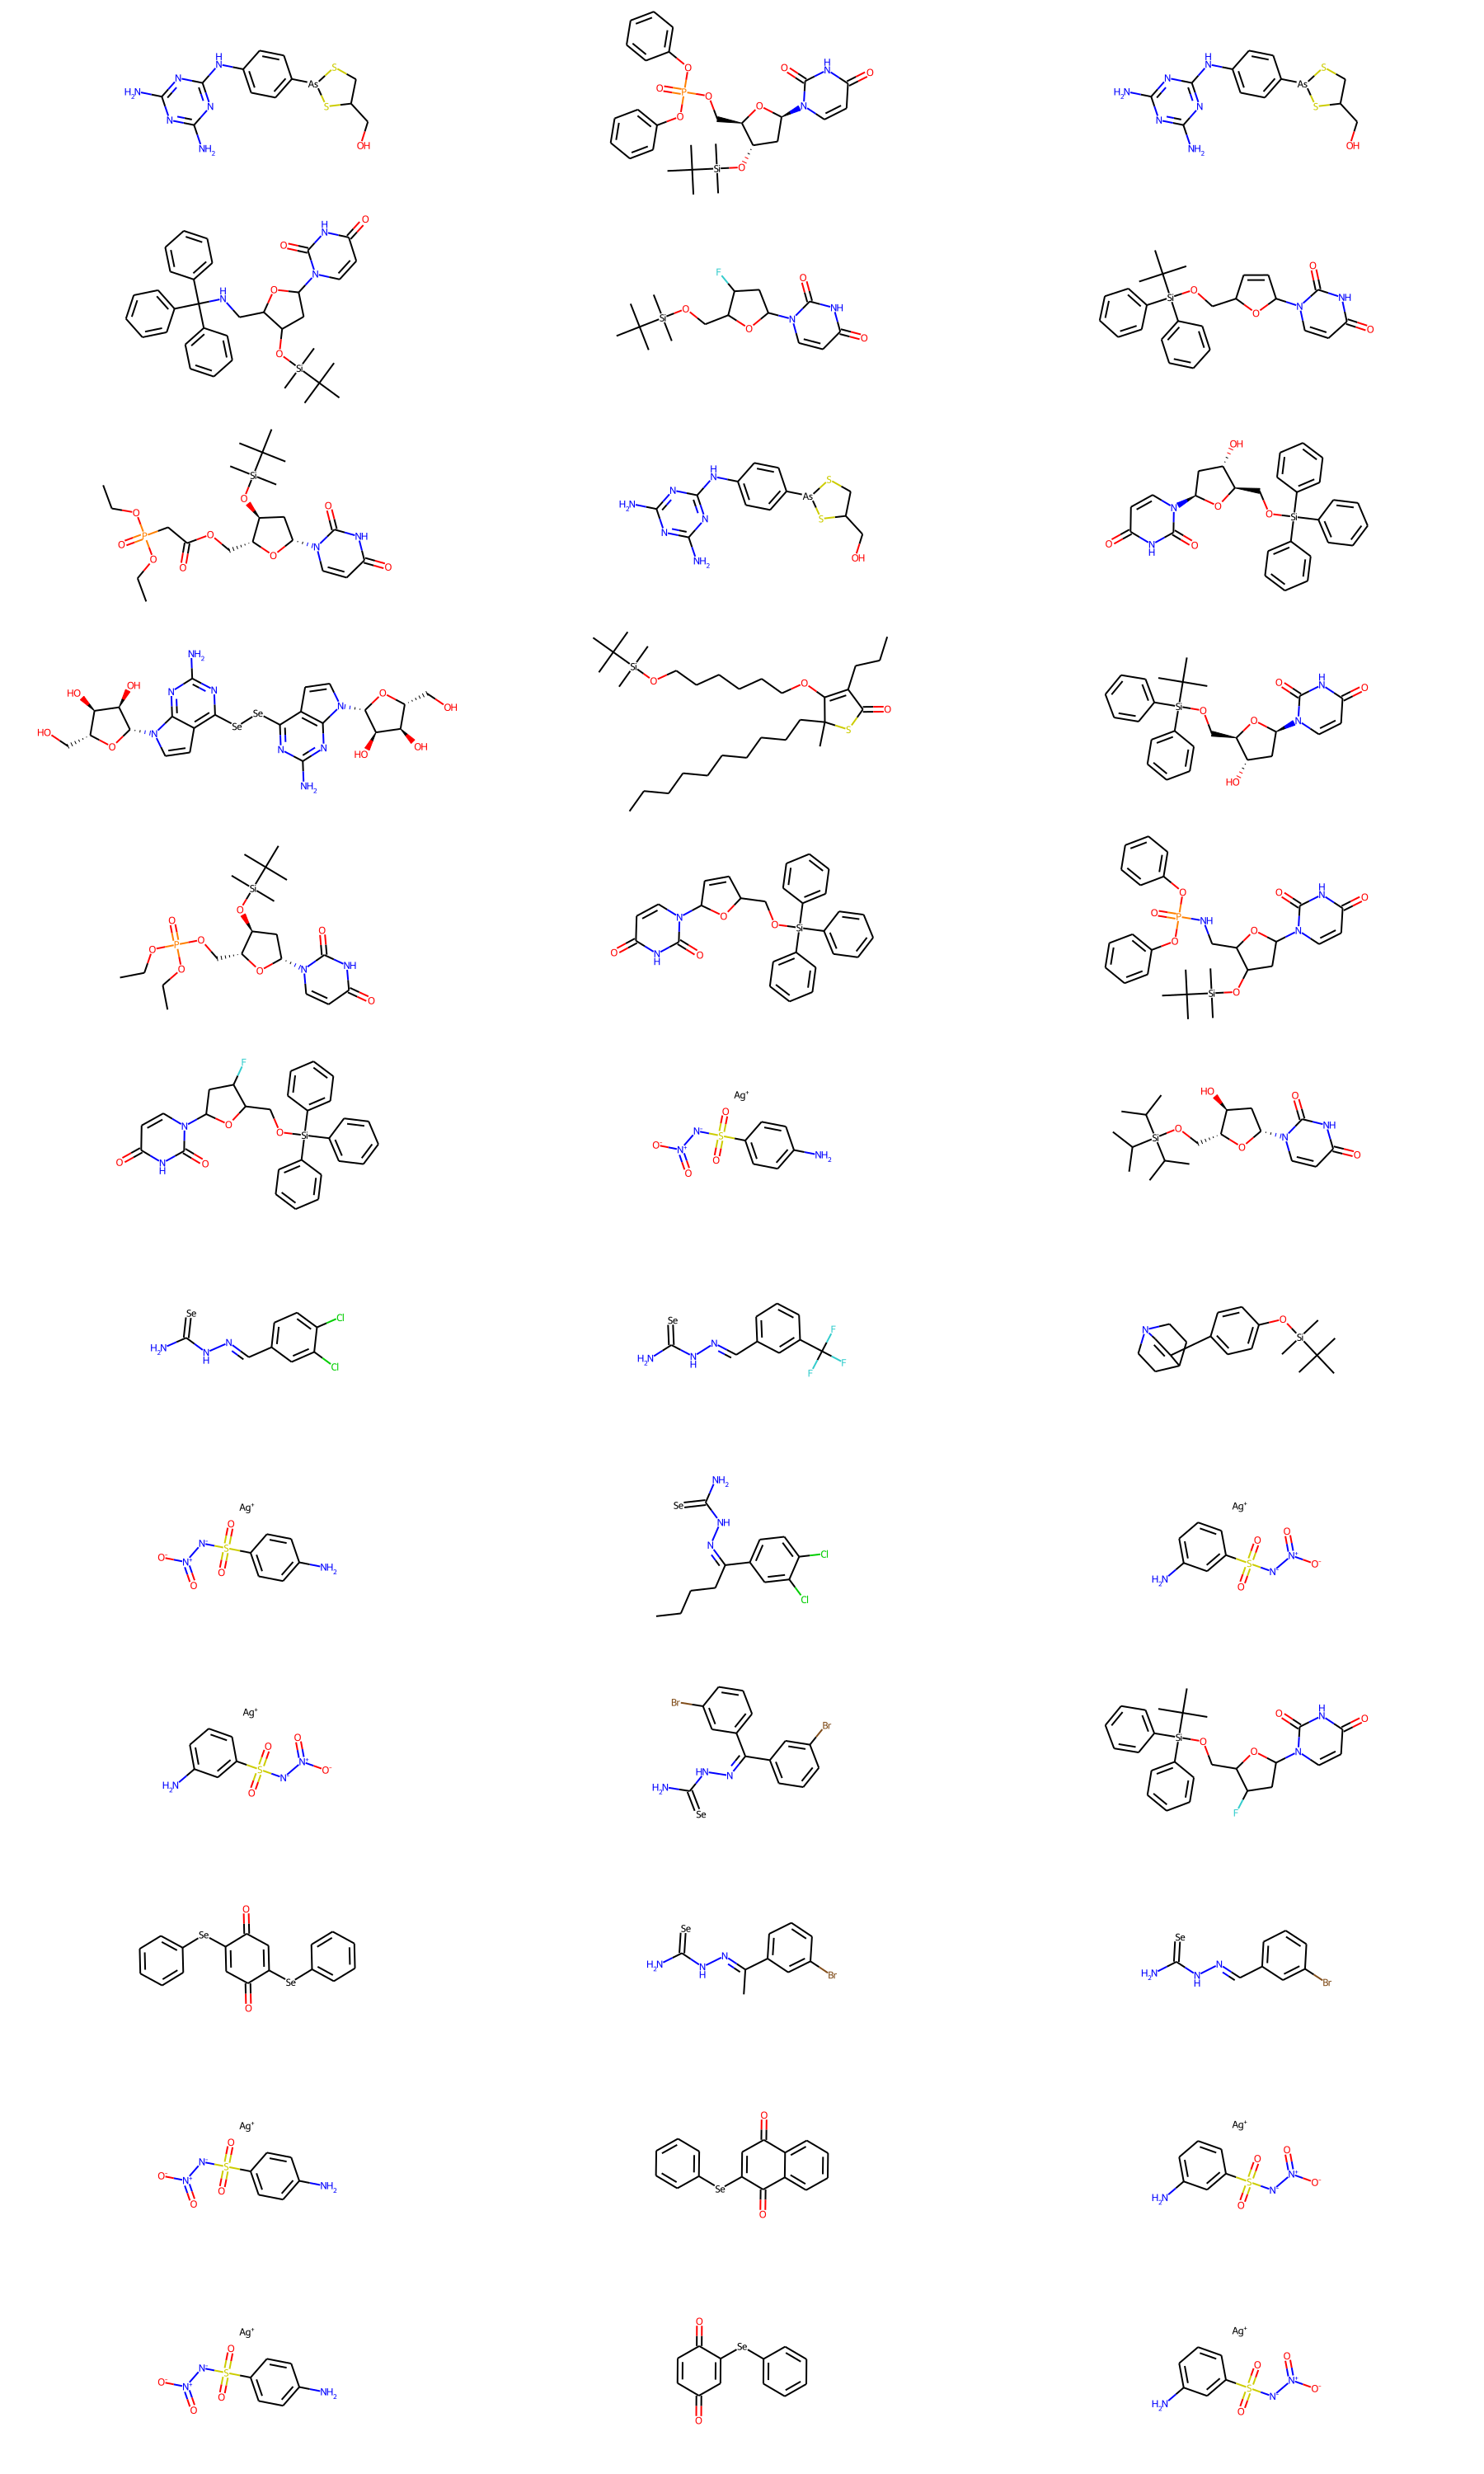

In [8]:
not_org_df = df_chembl[df_chembl["not_org"] == 1]
not_org_mol_list = not_org_df['Smiles'].apply(Chem.MolFromSmiles)

Chem.Draw.MolsToGridImage(not_org_mol_list, molsPerRow=3, subImgSize=(600,250))

Note a presença de átomos como Ag, As, Se, Si. 

Lembre-se de que a opção de quais átomos incluir ou remover dependerá da sua análise e dos seus objetivos.